In [1]:
import os
import cv2
import easyocr
import numpy as np
import matplotlib.pyplot as plt

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [2]:
from PIL import Image

# Load the image
image_path = "./whole_img.jpg"
image = Image.open(image_path)
image.show()

# Get image dimensions
image_width, image_height = image.size

# Define cropping areas as percentages
crop_areas_percentage = [
    (0.01, 0.09, 0.27, 0.83),
    (0.24, 0.08, 0.83, 0.83),
    (0.01, 0.80, 0.8, 1),
    (0.8, 0.09, 1, 1),
    (0.24, 0, 1, 0.1)
]

names = ['analog_image', 'mid_image', 'bottom_image', 'right_image', 'top_image']

# Crop and save each section
for i, (left_pct, top_pct, right_pct, bottom_pct) in enumerate(crop_areas_percentage):
    left = int(left_pct * image_width)
    top = int(top_pct * image_height)
    right = int(right_pct * image_width)
    bottom = int(bottom_pct * image_height)
    
    cropped_image = image.crop((left, top, right, bottom))
    cropped_image.save(f"{names[i]}.jpeg")

print("Cropping complete!")


Cropping complete!


Using CPU. Note: This module is much faster with a GPU.


-------------------- Recognized Elements ----------------------


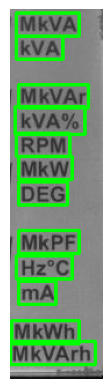

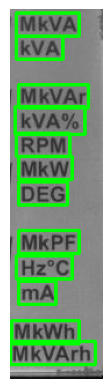

Using CPU. Note: This module is much faster with a GPU.


Recognized Elements:
MkVA 			:	 0.96
kVA 			:	 0.55
MkVAr 			:	 1.00
kVA% 			:	 0.91
RPM 			:	 1.00
MkW 			:	 0.96
DEG 			:	 1.00
MkPF 			:	 1.00
Hz'c 			:	 0.56
MA 			:	 0.76
MkWh 			:	 0.99
MkVArh 			:	 1.00


Total Recognized Elements: 12
['MkVA', 'kVA', 'MkVAr', 'kVA%', 'RPM', 'MkW', 'DEG', 'MkPF', "Hz'c", 'MA', 'MkWh', 'MkVArh']
-------------------- Recognized Elements ----------------------


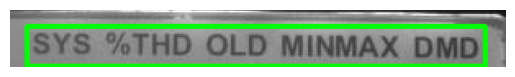

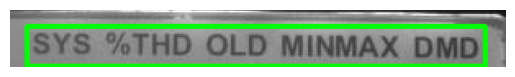

Recognized Elements:
SYS %THD OLD MINMAX DMD 			:	 0.71


Total Recognized Elements: 1
['SYS %THD OLD MINMAX DMD']


In [3]:
def process_image(image_name):
    # Initialize EasyOCR Reader
    reader = easyocr.Reader(['en'], gpu=False)

    # Load and display the image
    image_path = f"./{image_name}.jpeg"
    image = cv2.imread(image_path)
    plt.imshow(image)
    plt.axis('off')

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to isolate segments
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Detect contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a copy of the image
    image_contours = image.copy()
    cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 2)

    # Perform OCR using EasyOCR
    results = reader.readtext(gray)
    keys, values = [], []

    for (_, text, prob) in results:
        keys.append(text)
        values.append(prob)

    # Draw bounding boxes and display recognized text with high confidence
    print("-------------------- Recognized Elements ----------------------")
    for (bbox, text, prob) in results:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))

        if prob > 0.50:
            cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Draw bounding boxes for low confidence results
    for (bbox, text, prob) in results:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))

        if prob < 0.50:
            cv2.rectangle(image, top_left, bottom_right, (0, 0, 255), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Print recognized elements with probabilities
    print("Recognized Elements:")
    for text, probability in zip(keys, values):
        flag = ' <--- ' if probability < 0.50 else ''
        print(f"{text} \t\t\t:\t {probability:.2f}{flag}")

    print("\n\nTotal Recognized Elements:", len(keys))
    return keys, values

# Process images
names = ['right_image', 'top_image']
for name in names:
    keys, values = process_image(name)
    print(keys)